<a href="https://colab.research.google.com/github/bheemeshpujari63/AI-Suicide-Prevention-Reddit/blob/main/AI_Suicide_Prevention_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Powered Suicide Prevention from Reddit (GSoC Submission)

## **1. Setup & Installation**
- Install required libraries.

In [3]:
# Install dependencies
!pip install vaderSentiment gensim pandas matplotlib folium nltk spacy praw
!python -m spacy download en_core_web_sm
!python -m nltk.downloader punkt

# Import libraries
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import folium
from folium.plugins import HeatMap
import spacy
import nltk

print("Setup Complete")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 126.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Setup Complete


## Task-1

In [4]:

import praw
import pandas as pd
import re
import string
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import drive
import nltk
import os

# Initialize NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Mount Google Drive
drive.mount('/content/drive')

# Reddit API Credentials (Replace with your own)
CLIENT_ID = "******"
CLIENT_SECRET = "******"
USER_AGENT = "*****"

# Crisis-related keywords (Expanded list)
KEYWORDS = [
    "suicidal", "depressed", "self-harm", "overwhelmed",
    "panic attack", "mental breakdown", "hopeless",
    "addiction", "relapse", "substance abuse",
    "therapy", "counseling", "mental health crisis",
    "lonely", "isolated", "want to die"
]

# Target subreddits
SUBREDDITS = [
    "depression",
    "mentalhealth",
    "SuicideWatch",
    "addiction",
    "anxiety"
]

# Output paths in Google Drive
OUTPUT_FOLDER = "/content/drive/MyDrive/Reddit_Mental-Health_Data"
RAW_DATA_PATH = f"{OUTPUT_FOLDER}/reddit_raw_data.csv"
CLEANED_DATA_PATH = f"{OUTPUT_FOLDER}/reddit_cleaned_data.csv"

def create_output_folder():
    """Create output folder in Google Drive if it doesn't exist"""
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)
        print(f"Created directory: {OUTPUT_FOLDER}")

def authenticate_reddit():
    """Authenticate with Reddit API with error handling"""
    try:
        reddit = praw.Reddit(
            client_id=CLIENT_ID,
            client_secret=CLIENT_SECRET,
            user_agent=USER_AGENT
        )
        # Verify authentication
        if reddit.user.me() is None:
            print("Successfully authenticated (read-only mode)")
        return reddit
    except Exception as e:
        print(f"Reddit authentication failed: {str(e)}")
        raise

def extract_posts(reddit):
    """Extract posts with enhanced error handling and progress tracking"""
    posts_data = []
    total_extracted = 0

    for subreddit_name in SUBREDDITS:
        print(f"\n🔍 Searching r/{subreddit_name}...")

        try:
            subreddit = reddit.subreddit(subreddit_name)

            for keyword in KEYWORDS:
                print(f"   Searching for: '{keyword}'")

                try:
                    for post in subreddit.search(keyword, limit=25, time_filter='month'):
                        posts_data.append({
                            "post_id": post.id,
                            "timestamp": datetime.utcfromtimestamp(post.created_utc).isoformat(),
                            "subreddit": subreddit_name,
                            "keyword": keyword,
                            "title": post.title,
                            "content": post.selftext,
                            "upvotes": post.score,
                            "comments": post.num_comments,
                            "url": f"https://reddit.com{post.permalink}"
                        })
                        total_extracted += 1

                except Exception as search_error:
                    print(f"Error searching '{keyword}': {str(search_error)}")
                    continue

        except Exception as subreddit_error:
            print(f"Error accessing r/{subreddit_name}: {str(subreddit_error)}")
            continue

    print(f"\n Successfully extracted {total_extracted} posts")
    return posts_data

def clean_text(text):
    """Enhanced text cleaning with emoji removal and lemmatization"""
    if not isinstance(text, str) or not text.strip():
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove special chars and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text.strip()

def save_data(df, path):
    """Save DataFrame with error handling"""
    try:
        df.to_csv(path, index=False)
        print(f" Data saved to {path}")
    except Exception as e:
        print(f"Failed to save data: {str(e)}")

def main():
    """Main execution flow with progress tracking"""
    print("🚀 Starting Reddit Mental Health Data Extraction")

    create_output_folder()

    try:
        # Authentication
        print("\n Authenticating with Reddit API...")
        reddit = authenticate_reddit()

        # Data extraction
        print("\n Extracting posts...")
        posts = extract_posts(reddit)

        if not posts:
            print(" No posts extracted. Exiting.")
            return

        df = pd.DataFrame(posts)

        # Data cleaning
        print("\n Cleaning data...")
        df['cleaned_content'] = df['content'].apply(clean_text)
        df['cleaned_title'] = df['title'].apply(clean_text)

        # Save data
        print("\n Saving results...")
        save_data(df, RAW_DATA_PATH)

        # Create cleaned version
        cleaned_df = df.drop(columns=['content', 'title'])
        save_data(cleaned_df, CLEANED_DATA_PATH)

        # Preview
        print("\n Sample of cleaned data:")
        display(cleaned_df.head(3))

    except Exception as e:
        print(f"\n Script failed: {str(e)}")
    finally:
        print("\n Script completed")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
🚀 Starting Reddit Mental Health Data Extraction


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




 Authenticating with Reddit API...
Successfully authenticated (read-only mode)

 Extracting posts...

🔍 Searching r/depression...
   Searching for: 'suicidal'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'depressed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'self-harm'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'overwhelmed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'panic attack'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental breakdown'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'hopeless'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'addiction'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'relapse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'substance abuse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'therapy'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'counseling'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental health crisis'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'lonely'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'isolated'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'want to die'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔍 Searching r/mentalhealth...
   Searching for: 'suicidal'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'depressed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'self-harm'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'overwhelmed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'panic attack'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental breakdown'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'hopeless'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'addiction'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'relapse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'substance abuse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'therapy'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'counseling'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental health crisis'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'lonely'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'isolated'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'want to die'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔍 Searching r/SuicideWatch...
   Searching for: 'suicidal'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'depressed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'self-harm'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'overwhelmed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'panic attack'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental breakdown'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'hopeless'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'addiction'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'relapse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'substance abuse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'therapy'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'counseling'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental health crisis'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'lonely'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'isolated'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'want to die'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔍 Searching r/addiction...
   Searching for: 'suicidal'
   Searching for: 'depressed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'self-harm'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'overwhelmed'
   Searching for: 'panic attack'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental breakdown'
   Searching for: 'hopeless'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'addiction'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'relapse'
   Searching for: 'substance abuse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'therapy'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'counseling'
   Searching for: 'mental health crisis'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'lonely'
   Searching for: 'isolated'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'want to die'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔍 Searching r/anxiety...
   Searching for: 'suicidal'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'depressed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'self-harm'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'overwhelmed'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'panic attack'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental breakdown'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'hopeless'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'addiction'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'relapse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'substance abuse'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'therapy'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'counseling'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'mental health crisis'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'lonely'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'isolated'


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



   Searching for: 'want to die'

 Successfully extracted 1535 posts

 Cleaning data...

 Saving results...
 Data saved to /content/drive/MyDrive/Reddit_Mental-Health_Data/reddit_raw_data.csv
 Data saved to /content/drive/MyDrive/Reddit_Mental-Health_Data/reddit_cleaned_data.csv

 Sample of cleaned data:


,post_id,timestamp,subreddit,keyword,upvotes,comments,url,cleaned_content,cleaned_title
0,own79d,2021-08-02T20:33:09,depression,suicidal,302,2,https://reddit.com/r/u_RedditCareResources/com...,youd like talk someone confidential mental hea...,get support people
1,1jd1y5e,2025-03-17T02:02:28,depression,suicidal,654,118,https://reddit.com/r/depression/comments/1jd1y...,im half asian household mother chinese dad whi...,mom told commit suicide
2,1ju1k9e,2025-04-08T01:09:50,depression,suicidal,1044,65,https://reddit.com/r/depression/comments/1ju1k...,unhappy life abusive father sadly couldnt anyt...,girlfriend suicided today



 Script completed


## Task 2

In [5]:
cleaned_df = pd.read_csv("/content/drive/MyDrive/Reddit_Mental-Health_Data/reddit_cleaned_data.csv")
cleaned_df

,post_id,timestamp,subreddit,keyword,upvotes,comments,url,cleaned_content,cleaned_title
0,own79d,2021-08-02T20:33:09,depression,suicidal,302,2,https://reddit.com/r/u_RedditCareResources/com...,youd like talk someone confidential mental hea...,get support people
1,1jd1y5e,2025-03-17T02:02:28,depression,suicidal,654,118,https://reddit.com/r/depression/comments/1jd1y...,im half asian household mother chinese dad whi...,mom told commit suicide
2,1ju1k9e,2025-04-08T01:09:50,depression,suicidal,1044,65,https://reddit.com/r/depression/comments/1ju1k...,unhappy life abusive father sadly couldnt anyt...,girlfriend suicided today
3,1jsen3q,2025-04-05T21:50:21,depression,suicidal,585,86,https://reddit.com/r/depression/comments/1jsen...,died revived attempt forced psychiatric hospit...,survived suicide still wish dead
4,1j9j2ky,2025-03-12T12:37:36,depression,suicidal,573,82,https://reddit.com/r/depression/comments/1j9j2...,im suicidal good life standard good life suppo...,suicidal wouldnt mind waking tomorrow
...,...,...,...,...,...,...,...,...,...
1530,1j79igs,2025-03-09T15:05:44,anxiety,want to die,1,14,https://reddit.com/r/Anxiety/comments/1j79igs/...,supposed anything accomplish anything live lif...,please help
1531,1jb3x2n,2025-03-14T13:29:10,anxiety,want to die,8,12,https://reddit.com/r/Anxiety/comments/1jb3x2n/...,struggling health anxiety since dad almost pas...,desperately need success story overcoming heal...
1532,1ji0zg1,2025-03-23T14:50:53,anxiety,want to die,2,11,https://reddit.com/r/Anxiety/comments/1ji0zg1/...,anxiety check back worse ever constantly think...,anxiety really bad atm
1533,1jeu1tj,2025-03-19T10:41:25,anxiety,want to die,2,11,https://reddit.com/r/Anxiety/comments/1jeu1tj/...,every time anxiety attack last week want die w...,anxiety attack left death wish


In [6]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import folium
from folium.plugins import HeatMap
import spacy

In [7]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data Loaded Successfully


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Results saved to /content/drive/MyDrive/Reddit_Mental-Health_Data/Analysis_Results/reddit_crisis_data_analyzed.csv
Visualization saved to /content/drive/MyDrive/Reddit_Mental-Health_Data/Analysis_Results/sentiment_risk_distribution.png


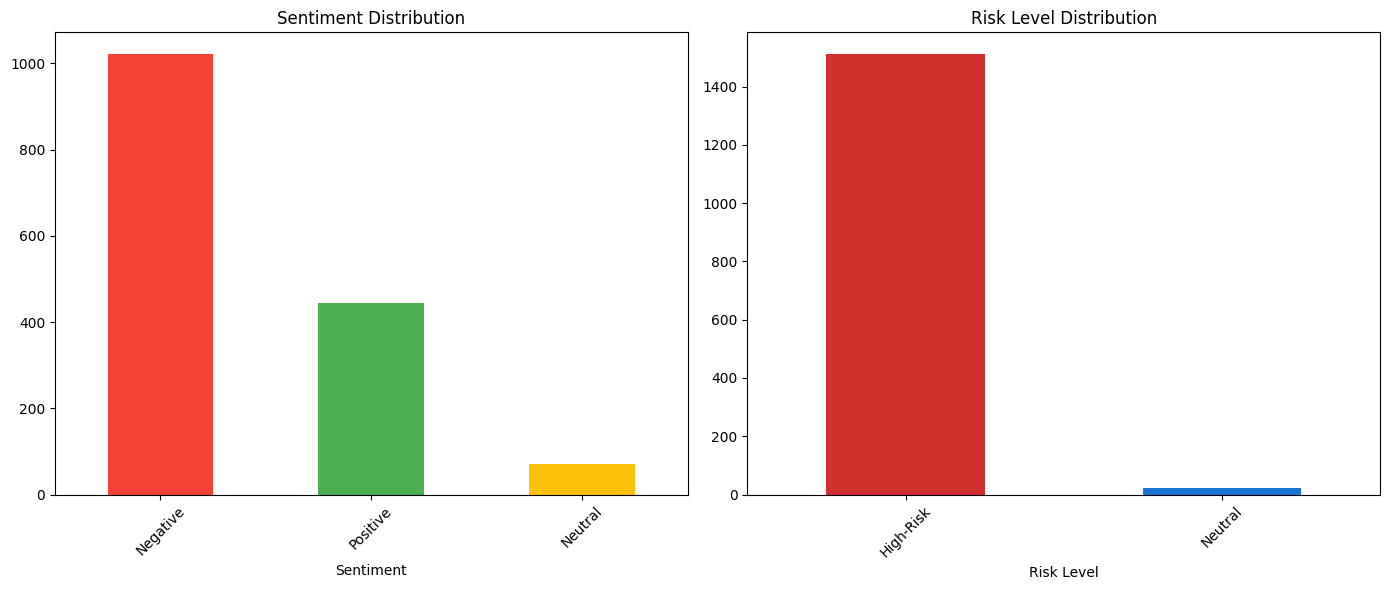


Analysis Complete!


In [8]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
base_dir = "/content/drive/MyDrive/Reddit_Mental-Health_Data"
output_dir = os.path.join(base_dir, "Analysis_Results")
os.makedirs(output_dir, exist_ok=True)

# Load cleaned data
cleaned_df = pd.read_csv(os.path.join(base_dir, "reddit_cleaned_data.csv"))
print("Data Loaded Successfully")

# Tokenization
nltk.download('punkt')
cleaned_df["Tokens"] = cleaned_df["cleaned_content"].fillna("").apply(word_tokenize)

# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    if not isinstance(text, str):
        text = ""
    score = analyzer.polarity_scores(text)["compound"]
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

cleaned_df["Sentiment"] = cleaned_df["cleaned_content"].apply(get_sentiment)

# Word2Vec Model Training
w2v_model = Word2Vec(
    sentences=cleaned_df["Tokens"].tolist(),
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)

# Define Risk Terms
HIGH_RISK_TERMS = ["dont want to be here", "kill myself", "end it", "suicidal",
                  "want to die", "no point living", "give up"]
MODERATE_RISK_TERMS = ["help me", "feel lost", "struggling", "overwhelmed",
                      "cant cope", "need support", "breaking down"]
LOW_RISK_TERMS = ["therapy", "counseling", "recovery", "meditation",
                 "self care", "wellness", "support group"]

# Preprocess risk terms
high_risk_tokens = [word_tokenize(phrase.lower()) for phrase in HIGH_RISK_TERMS]
moderate_risk_tokens = [word_tokenize(phrase.lower()) for phrase in MODERATE_RISK_TERMS]
low_risk_tokens = [word_tokenize(phrase.lower()) for phrase in LOW_RISK_TERMS]

# Enhanced Risk Classification
def get_word2vec_similarity(tokens, risk_tokens_list, model):
    max_similarity = 0
    for risk_tokens in risk_tokens_list:
        for token in tokens:
            for risk_token in risk_tokens:
                try:
                    similarity = model.wv.similarity(token, risk_token)
                    max_similarity = max(max_similarity, similarity)
                except KeyError:
                    continue
    return max_similarity

def classify_risk(tokens, model):
    high_risk_score = get_word2vec_similarity(tokens, high_risk_tokens, model)
    moderate_risk_score = get_word2vec_similarity(tokens, moderate_risk_tokens, model)
    low_risk_score = get_word2vec_similarity(tokens, low_risk_tokens, model)

    if high_risk_score > 0.7:
        return "High-Risk"
    elif moderate_risk_score > 0.6:
        return "Moderate Concern"
    elif low_risk_score > 0.5:
        return "Low Concern"
    else:
        return "Neutral"

cleaned_df["Risk Level"] = cleaned_df["Tokens"].apply(lambda tokens: classify_risk(tokens, w2v_model))

# Save Results
output_csv_path = os.path.join(output_dir, "reddit_crisis_data_analyzed.csv")
cleaned_df.to_csv(output_csv_path, index=False)
print(f"Results saved to {output_csv_path}")

# Enhanced Visualization
plt.figure(figsize=(14, 6))

# Sentiment Plot with custom colors
plt.subplot(1, 2, 1)
sentiment_colors = {'Positive': '#4CAF50', 'Negative': '#F44336', 'Neutral': '#FFC107'}
cleaned_df["Sentiment"].value_counts().plot(
    kind="bar",
    title="Sentiment Distribution",
    color=[sentiment_colors[x] for x in cleaned_df["Sentiment"].value_counts().index]
)
plt.xticks(rotation=45)

# Risk Level Plot with custom colors
plt.subplot(1, 2, 2)
risk_colors = {
    'High-Risk': '#D32F2F',
    'Moderate Concern': '#FFA000',
    'Low Concern': '#388E3C',
    'Neutral': '#1976D2'
}
cleaned_df["Risk Level"].value_counts().plot(
    kind="bar",
    title="Risk Level Distribution",
    color=[risk_colors[x] for x in cleaned_df["Risk Level"].value_counts().index]
)
plt.xticks(rotation=45)

plt.tight_layout()

# Save visualization
plot_path = os.path.join(output_dir, "sentiment_risk_distribution.png")
plt.savefig(plot_path, bbox_inches='tight', dpi=300)
print(f"Visualization saved to {plot_path}")
plt.show()

print("\nAnalysis Complete!")

## Task 3

In [9]:
import pandas as pd
import numpy as np
import re
import spacy
import folium
from folium.plugins import HeatMap
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from collections import Counter
import time
import os

# Set up directory structure
base_dir = "/content/drive/MyDrive/Reddit_Mental-Health_Data"
output_dir = os.path.join(base_dir, "Analysis_Results")
os.makedirs(output_dir, exist_ok=True)

# Load the dataset
# Using the proper path with the directory structure
data = pd.read_csv(os.path.join(output_dir, "reddit_crisis_data_analyzed.csv"))

# Load SpaCy NLP model for named entity recognition
print("Loading SpaCy model...")
nlp = spacy.load("en_core_web_sm")

def extract_locations(text):
    """Extract location entities from text using SpaCy"""
    if not isinstance(text, str):
        return []

    doc = nlp(text)
    locations = []

    # Extract location entities (GPE = Geo-Political Entity, LOC = Location)
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC"]:
            locations.append(ent.text)

    return locations

def geocode_location(location_name):
    """Convert location name to coordinates"""
    geolocator = Nominatim(user_agent="crisis_analyzer")
    try:
        # Add "USA" to improve geocoding for US locations
        location = geolocator.geocode(f"{location_name}, USA", exactly_one=True)
        if location is None:
            location = geolocator.geocode(location_name, exactly_one=True)

        if location:
            return (location.latitude, location.longitude)
        return None
    except (GeocoderTimedOut, GeocoderUnavailable):
        # Handle timeouts by waiting and retrying once
        time.sleep(1)
        try:
            location = geolocator.geocode(location_name, exactly_one=True)
            if location:
                return (location.latitude, location.longitude)
            return None
        except (GeocoderTimedOut, GeocoderUnavailable):
            return None

# Extract locations from post titles and content
print("Extracting locations from dataset...")
data['extracted_locations'] = data['cleaned_content'].apply(extract_locations)

# If there's a 'text' or 'content' column, extract from there too
if 'text' in data.columns:
    data['content_locations'] = data['text'].apply(extract_locations)
    # Combine locations from title and content
    data['extracted_locations'] = data.apply(
        lambda row: row['extracted_locations'] + row['content_locations'], axis=1
    )
elif 'content' in data.columns:
    data['content_locations'] = data['content'].apply(extract_locations)
    # Combine locations from title and content
    data['extracted_locations'] = data.apply(
        lambda row: row['extracted_locations'] + row['content_locations'], axis=1
    )

# Get frequency count of all locations
all_locations = []
for loc_list in data['extracted_locations']:
    all_locations.extend(loc_list)

location_counts = Counter(all_locations)
print(f"Found {len(location_counts)} unique locations")

# Get the top 50 locations to geocode (to avoid geocoding all minor mentions)
top_locations = location_counts.most_common(50)
print("Top 10 locations mentioned:")
for loc, count in top_locations[:10]:
    print(f"- {loc}: {count} mentions")

# Create a dictionary to store location coordinates
location_coordinates = {}

print("Geocoding locations...")
for location, count in top_locations:
    coords = geocode_location(location)
    if coords:
        location_coordinates[location] = coords
        print(f"Geocoded {location} to {coords}")
    else:
        print(f"Could not geocode {location}")
    # Be nice to the geocoding service with a delay
    time.sleep(0.5)

print(f"Successfully geocoded {len(location_coordinates)} locations")

# Create a dataset for the heatmap
heatmap_data = []
for location, coords in location_coordinates.items():
    weight = location_counts[location]  # Use the count as weight
    lat, lon = coords
    heatmap_data.append([lat, lon, weight])

# Create Folium map centered on the US
map_center = [39.8283, -98.5795]  # Center of the US
crisis_map = folium.Map(location=map_center, zoom_start=4)

# Add the heatmap
HeatMap(heatmap_data).add_to(crisis_map)

# Save the map to the output directory
map_filename = os.path.join(output_dir, "crisis_heatmap.html")
crisis_map.save(map_filename)
print(f"Saved heatmap to {map_filename}")

# Create a dataframe for the top locations
top_locations_with_coords = []
for loc, count in top_locations:
    if loc in location_coordinates:
        lat, lon = location_coordinates[loc]
        top_locations_with_coords.append({
            'location': loc,
            'count': count,
            'latitude': lat,
            'longitude': lon
        })

top_df = pd.DataFrame(top_locations_with_coords)

# Get the top 5 locations
top_5_locations = top_df.nlargest(5, 'count')
print("\nTop 5 locations with highest crisis discussions:")
for i, row in top_5_locations.iterrows():
    print(f"{row['location']}: {row['count']} mentions")

# Create a Plotly map for the top 5 locations
fig = px.scatter_geo(
    top_5_locations,
    lat='latitude',
    lon='longitude',
    size='count',
    text='location',
    scope='usa',
    title='Top 5 Locations with Highest Crisis Discussions'
)

fig.update_traces(
    marker=dict(color='red', line=dict(width=1, color='DarkSlateGrey')),
    selector=dict(mode='markers+text'),
    textposition='top center'
)

# Save the Plotly map to the output directory
plotly_filename = os.path.join(output_dir, "top_locations_map.html")
fig.write_html(plotly_filename)
print(f"Saved top locations map to {plotly_filename}")

# Additional regional analysis - crisis by US region
def classify_region(lat, lon):
    """Classify coordinates into US regions"""
    # Simplified region classification based on lat/lon
    if lat > 39 and lon < -95:
        return "Northwest"
    elif lat > 39 and lon > -95:
        return "Northeast"
    elif lat <= 39 and lon < -95:
        return "Southwest"
    elif lat <= 39 and lon > -95:
        return "Southeast"
    else:
        return "Other"

# Add region classification to the dataframe
top_df['region'] = top_df.apply(
    lambda row: classify_region(row['latitude'], row['longitude']), axis=1
)

# Aggregate crisis mentions by region
region_counts = top_df.groupby('region')['count'].sum().reset_index()
print("\nCrisis discussion distribution by region:")
print(region_counts)

# Create a bar chart for regional distribution
fig_bar = px.bar(
    region_counts,
    x='region',
    y='count',
    title='Crisis Discussions by US Region',
    labels={'count': 'Number of Mentions', 'region': 'US Region'},
    color='region'
)

# Save the regional bar chart to the output directory
region_chart_filename = os.path.join(output_dir, "regional_distribution.html")
fig_bar.write_html(region_chart_filename)
print(f"Saved regional distribution chart to {region_chart_filename}")

# Save the processed data with location information to the output directory
data.to_csv(os.path.join(output_dir, "reddit_crisis_data_with_locations.csv"), index=False)
print("Saved processed data with location information")

print("\nAnalysis complete! Check the output files for visualizations.")

Loading SpaCy model...
Extracting locations from dataset...
Found 58 unique locations
Top 10 locations mentioned:
- kinda: 13 mentions
- phobia: 5 mentions
- canada: 4 mentions
- uk: 4 mentions
- malaysia: 4 mentions
- florida: 3 mentions
- netflix: 3 mentions
- america: 3 mentions
- pulseox: 3 mentions
- realy: 2 mentions
Geocoding locations...
Geocoded kinda to (34.637491779641046, -118.23898704762348)
Geocoded phobia to (32.7469774, -97.3254083)
Geocoded canada to (37.6056575, -82.3243095)
Geocoded uk to (38.026629099999994, -84.50472223981663)
Geocoded malaysia to (38.9437332, -77.06917697652096)
Geocoded florida to (27.7567667, -81.4639835)
Geocoded netflix to (40.76376354999999, -73.97430267133896)


Geocoded america to (39.7837304, -100.445882)


Could not geocode pulseox
Geocoded realy to (41.7978252, 12.2473553)
Geocoded sarasota to (27.3365805, -82.5308545)
Geocoded texas to (31.2638905, -98.5456116)
Geocoded india to (40.3764599, -79.1194757)
Geocoded toronto to (41.9048584, -90.8640346)


Geocoded turkey to (34.3939184, -100.894078)
Geocoded mexico city to (40.437631249999995, -80.00053119743275)


Could not geocode pregabalin zoloft
Geocoded france to (32.7569047, -97.0696914)
Geocoded london to (37.1283343, -84.0835576)
Geocoded denver to (39.7392364, -104.984862)
Geocoded tachycardia to (3.310225, 31.3847817)
Geocoded wisconsin to (44.4308975, -89.6884637)
Geocoded mexico to (39.1697626, -91.8829484)
Geocoded chicago to (41.8755616, -87.6244212)
Geocoded wisteria to (37.9792046, -122.02903575926116)
Geocoded grey to (48.40067355, -122.27823812395414)
Geocoded ncis to (38.5105247, -77.3895836)
Geocoded essentialy to (43.4498376, -80.488902)
Geocoded concerta to (39.8604393, -75.0874143)


Geocoded bluri to (-6.9173271, 112.4201995)
Geocoded manhattan to (40.7896239, -73.9598939)
Geocoded california to (36.7014631, -118.755997)
Geocoded new york to (40.7127281, -74.0060152)
Geocoded condo to (36.7322841, -76.59324541774532)
Geocoded belleville to (38.5135805, -89.9841627)
Geocoded europe to (40.704476, -74.01381414642856)
Geocoded missouri to (38.7604815, -92.5617875)
Geocoded poisin to (44.63376555104639, 7.4304054119608525)
Could not geocode asia youngest
Geocoded middle east to (39.3014159, -76.5888477)
Geocoded north korea to (40.7509106, -73.9710717)
Geocoded israel to (39.3181528, -79.8109014)
Could not geocode hemophobia
Geocoded georgia to (32.3293809, -83.1137366)
Geocoded colombia to (40.735546850000006, -73.86161701666221)
Geocoded spain to (45.7030061, -97.7859363)
Geocoded indonesia to (-4.5271203, 120.2077887)


Could not geocode hypochondria
Geocoded africa to (40.70447885, -74.01404387498147)
Could not geocode snris
Successfully geocoded 44 locations
Saved heatmap to /content/drive/MyDrive/Reddit_Mental-Health_Data/Analysis_Results/crisis_heatmap.html

Top 5 locations with highest crisis discussions:
kinda: 13 mentions
phobia: 5 mentions
canada: 4 mentions
uk: 4 mentions
malaysia: 4 mentions
Saved top locations map to /content/drive/MyDrive/Reddit_Mental-Health_Data/Analysis_Results/top_locations_map.html

Crisis discussion distribution by region:
      region  count
0  Northeast     25
1  Northwest      7
2  Southeast     27
3  Southwest     26
Saved regional distribution chart to /content/drive/MyDrive/Reddit_Mental-Health_Data/Analysis_Results/regional_distribution.html
Saved processed data with location information

Analysis complete! Check the output files for visualizations.
